# Mass Balance Analysis for the Determination of Partition Coefficients

Written by Christopher Farnin and Sean Orzolek

Please cite the following paper to reference this work: Farnin, C. J., Orzolek, S., & DuPont, J. N. A Novel Approach to Determine Variable Solute Partition Coefficients- Submitted to Metallurgical and Materials Transactions A.

The code requires the following packages:
Numpy
Pandas
Seaborn
Matplotlib
Os
Math
Scipy

In [1]:
# Imports the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline
import os
import math
from scipy.optimize import curve_fit

license= open(r'license.txt')
print(license.read())

MIT License

Copyright (c) [2020] [C. J. Farnin and S. Orzolek]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,


# Import EPMA and Phase Diagram Data

In [2]:
# Imports EPMA data from Excel file
trace= r'Co-Cu EPMA Data.xlsx'
data = pd.read_excel(trace)
data.head
[Len,Wid]=data.shape

#Imports ThermoCalc/Phase Diagram data from Excel file
phasediagram=r'TC Co-Cu Phase Diagram.xlsx'
pddata = pd.read_excel(phasediagram)
pddata.head

<bound method NDFrame.head of       Mass fraction of solid  Temperature [°C]  Mass percent of Co in FCC_L12  \
0               9.893800e-01           1236.58                       82.17595   
1               9.893700e-01           1236.68                       82.17337   
2               9.893700e-01           1236.78                       82.17080   
3               9.893700e-01           1236.88                       82.16823   
4               9.893700e-01           1236.98                       82.16566   
...                      ...               ...                            ...   
2266            1.134000e-02           1462.68                       93.15967   
2267            2.700000e-04           1462.78                       93.18067   
2268           -2.455920e-09           1462.87                       93.18097   
2269           -2.455920e-09           1462.87                       93.18096   
2270           -2.455920e-09           1462.87                       93.18096  

# Implement Weighted Interval Rank Sort (WIRS)

/Users/ChristopherFarnin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ChristopherFarnin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ChristopherFarnin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<function matplotlib.pyplot.show(*args, **kw)>

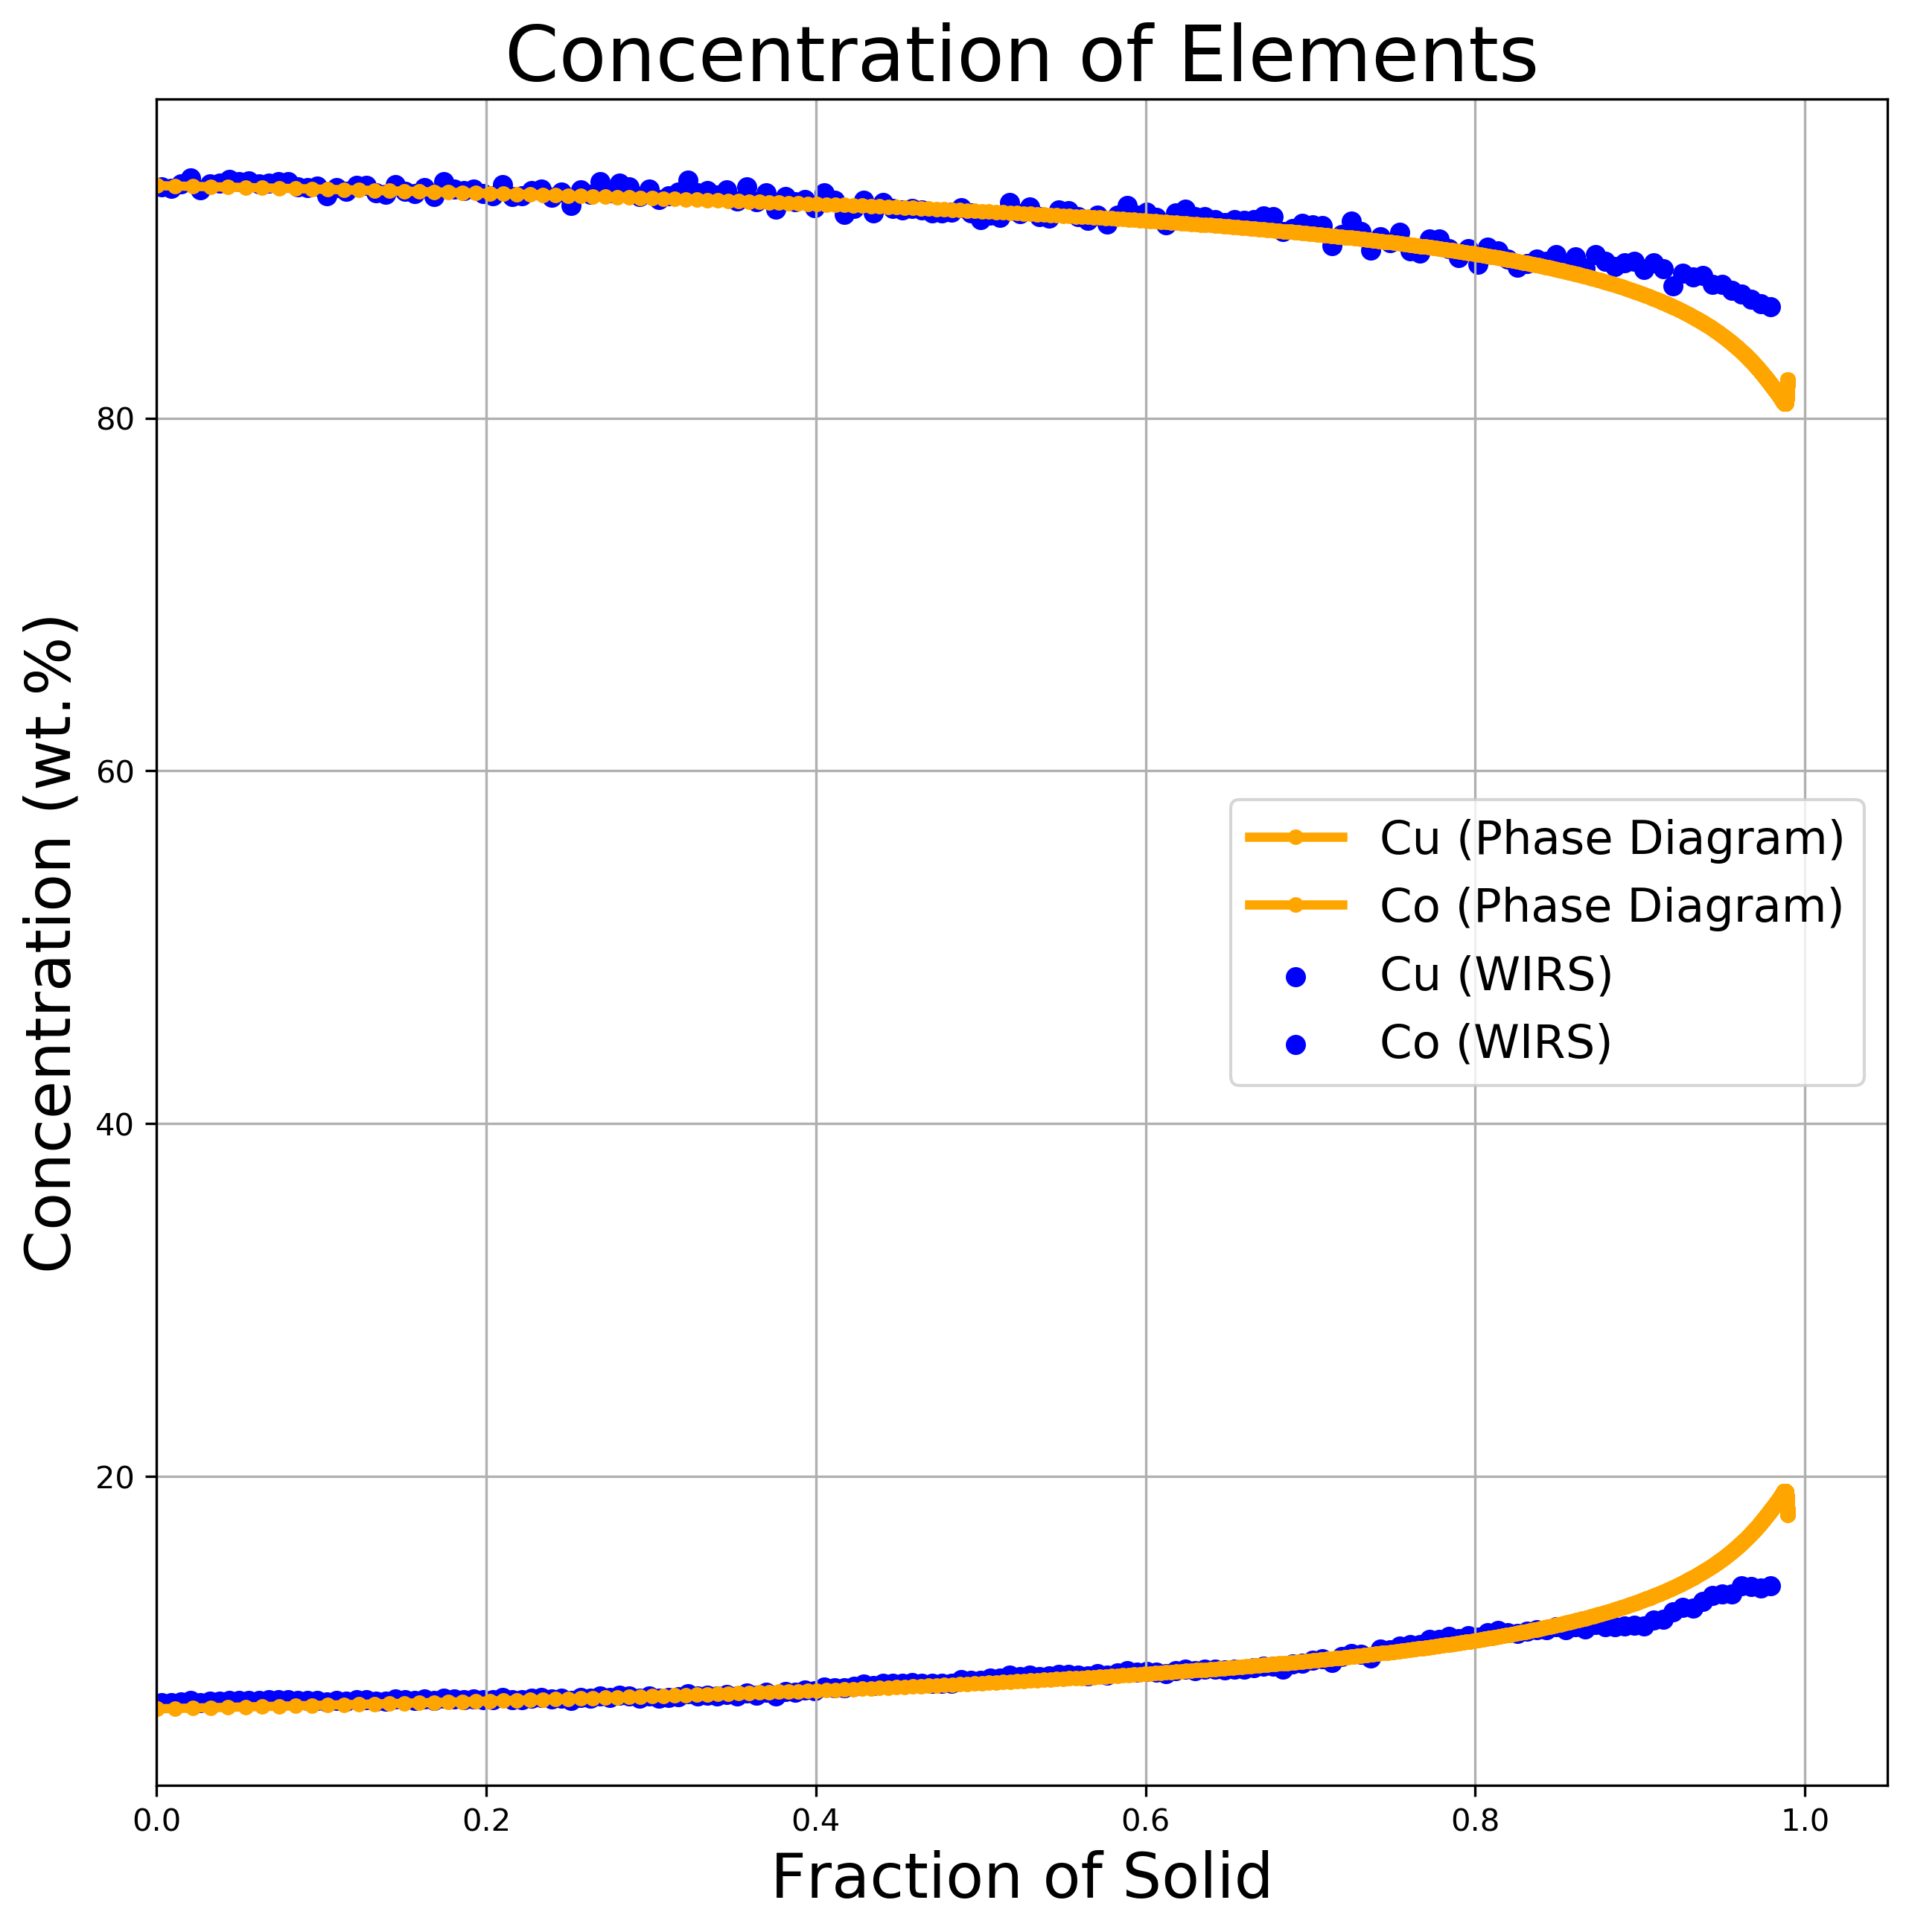

In [3]:
#filter dataset by total wt% to exclude unreliable EPMA datapoints
totalwtlow=98 
totalwthigh=102


#Applies the filter conditions to the dataframe
count_filter= ((data['Elemental Totals']>totalwtlow) & (data['Elemental Totals']<totalwthigh))
primary=data[count_filter]
primary.shape

#Set the nominal composition of the alloy in wt. %
C0Cu= 10
C0Co= 90

#Creates new dataframe
#Calculates and stores C-bar values for negatively segregating elements
primary['Cu_bar']=(primary["Cu Elemental Percents"] - primary["Cu Elemental Percents"].min())/((primary['Cu Percent Errors']/100)*primary['Cu Elemental Percents'])

#Calculates and stores C-bar values for positively segregating elements
primary['Co_bar']=(primary["Co Elemental Percents"].max() - primary["Co Elemental Percents"])/((primary['Co Percent Errors']/100)*primary['Co Elemental Percents'])

#Averages C-bar values to assign each composition point an average value
primary['Avgbar'] = primary[['Cu_bar', 'Co_bar']].mean(axis=1)

#Sorts grid points according to C-bar min to max
primary_sort=primary.sort_values(by=['Avgbar'])
primary_sort['Rank'] = primary_sort['Avgbar'].rank(ascending = 1)

#Assigns each EPMA point a value of fraction solid depending on its C-bar rank
primary_sort['Fsolid']=(primary_sort['Rank'] - 0.5)/primary_sort['Rank'].max()
primary_sort=primary_sort.reset_index(drop=True)

# Cut sorted data to a specified fraction solid
trimfs=0.98
primary_trim=primary_sort[(primary_sort["Fsolid"]<trimfs)]
primary_sort=primary_trim
f_solid=primary_sort['Fsolid']
f_solidi=primary_sort['Fsolid'].reset_index(drop=True)
primary_sort=primary_sort.reset_index(drop=True)


#Plots the WIRS solid composition profiles along side the Phase Diagram data
plt.figure(figsize=(10,10), dpi=300)
plt.plot(pddata['Mass fraction of solid'],pddata['Mass percent of Cu in FCC_L12'],label="Cu (Phase Diagram)",
         marker= 'o', markersize= 4, color= 'orange', linewidth= 3)
plt.plot(pddata['Mass fraction of solid'],pddata['Mass percent of Co in FCC_L12'],label="Co (Phase Diagram)",
         marker= 'o', markersize= 4, color= 'orange', linewidth= 3)
plt.scatter(primary_sort['Fsolid'],primary_sort['Cu Elemental Percents'],label="Cu (WIRS)",color='blue', s=30)
plt.scatter(primary_sort['Fsolid'],primary_sort['Co Elemental Percents'],label="Co (WIRS)",color='blue', s=30)
plt.xlim(0,1.05)
#plt.ylim(5, 20)
plt.xlabel('Fraction of Solid', fontsize=20)
plt.ylabel('Concentration (wt.%)', fontsize= 20)
plt.title("Concentration of Elements", fontsize=25)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.legend(fontsize=15)
plt.grid()
plt.show



## Calculation of k initial values

In [4]:
# Calculate kinit from the Dendrite Core
acore=15 #number of points to average from start of sorted data

KinitCo=primary_sort['Co Elemental Percents'].iloc[0:acore].mean(axis=0) / C0Co
print(KinitCo) #k initial for Cobalt

KinitCu=primary_sort['Cu Elemental Percents'].iloc[0:acore].mean(axis=0) / C0Cu
print(KinitCu) #k initial for Copper

1.0366960437037034
0.7260420333333333


## Calculation of k line values

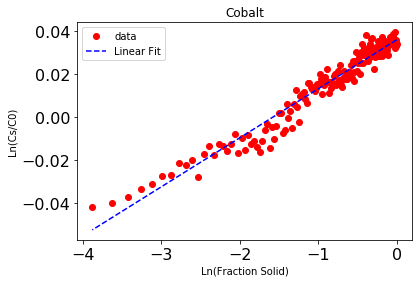

1.0360253089164955


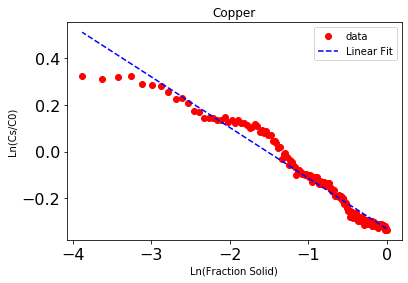

0.6690781573721851


In [5]:
# %% Calc from Curve
#log of Cs/C0 for the y axis
lnCsCu=np.log(primary_sort['Cu Elemental Percents'].div(C0Cu))
lnCsCo=np.log(primary_sort['Co Elemental Percents'].div(C0Co))

#log of the fraction liquid
lnFL=np.log(1-primary_sort['Fsolid'])
FL=1-primary_sort['Fsolid']
FS=primary_sort['Fsolid']

# Function for the linear scheil equation
def test(F,a,b): #F=Fraction solid, a is the slope and b is the y intercept
    return (a-1)*np.log(1-F)+(b)
#Fit the linear scheil to a linear fit to extract parameters
Cuparam, Cuparam_cov = curve_fit(test, FS, lnCsCu) 
Coparam, Coparam_cov = curve_fit(test, FS, lnCsCo) 
  

# Use the coefficients given by curve-fit() function to calculate linear fit
ansCo = test(FS,Coparam[0],Coparam[1])
ansCu = test(FS,Cuparam[0],Cuparam[1])

#Plots the data and line of best fit
plt.plot(lnFL, lnCsCo , 'o', color ='red', label ="data") 
plt.plot(lnFL, ansCo, '--', color ='blue', label ="Linear Fit") 
plt.legend()
plt.title("Cobalt")
plt.xlabel('Ln(Fraction Solid)')
plt.ylabel('Ln(Cs/C0)') 
plt.show()

KCo_line=abs(1+Coparam[1])
print(KCo_line)


plt.plot(lnFL, lnCsCu, 'o', color ='red', label ="data") 
plt.plot(lnFL, ansCu, '--', color ='blue', label ="Linear Fit") 
plt.legend() 
plt.title("Copper")
plt.xlabel('Ln(Fraction Solid)')
plt.ylabel('Ln(Cs/C0)') 
plt.show()


KCu_line=abs(1+Cuparam[1])
print(KCu_line)


# Mass Balance Approach for Determining k vs Fs

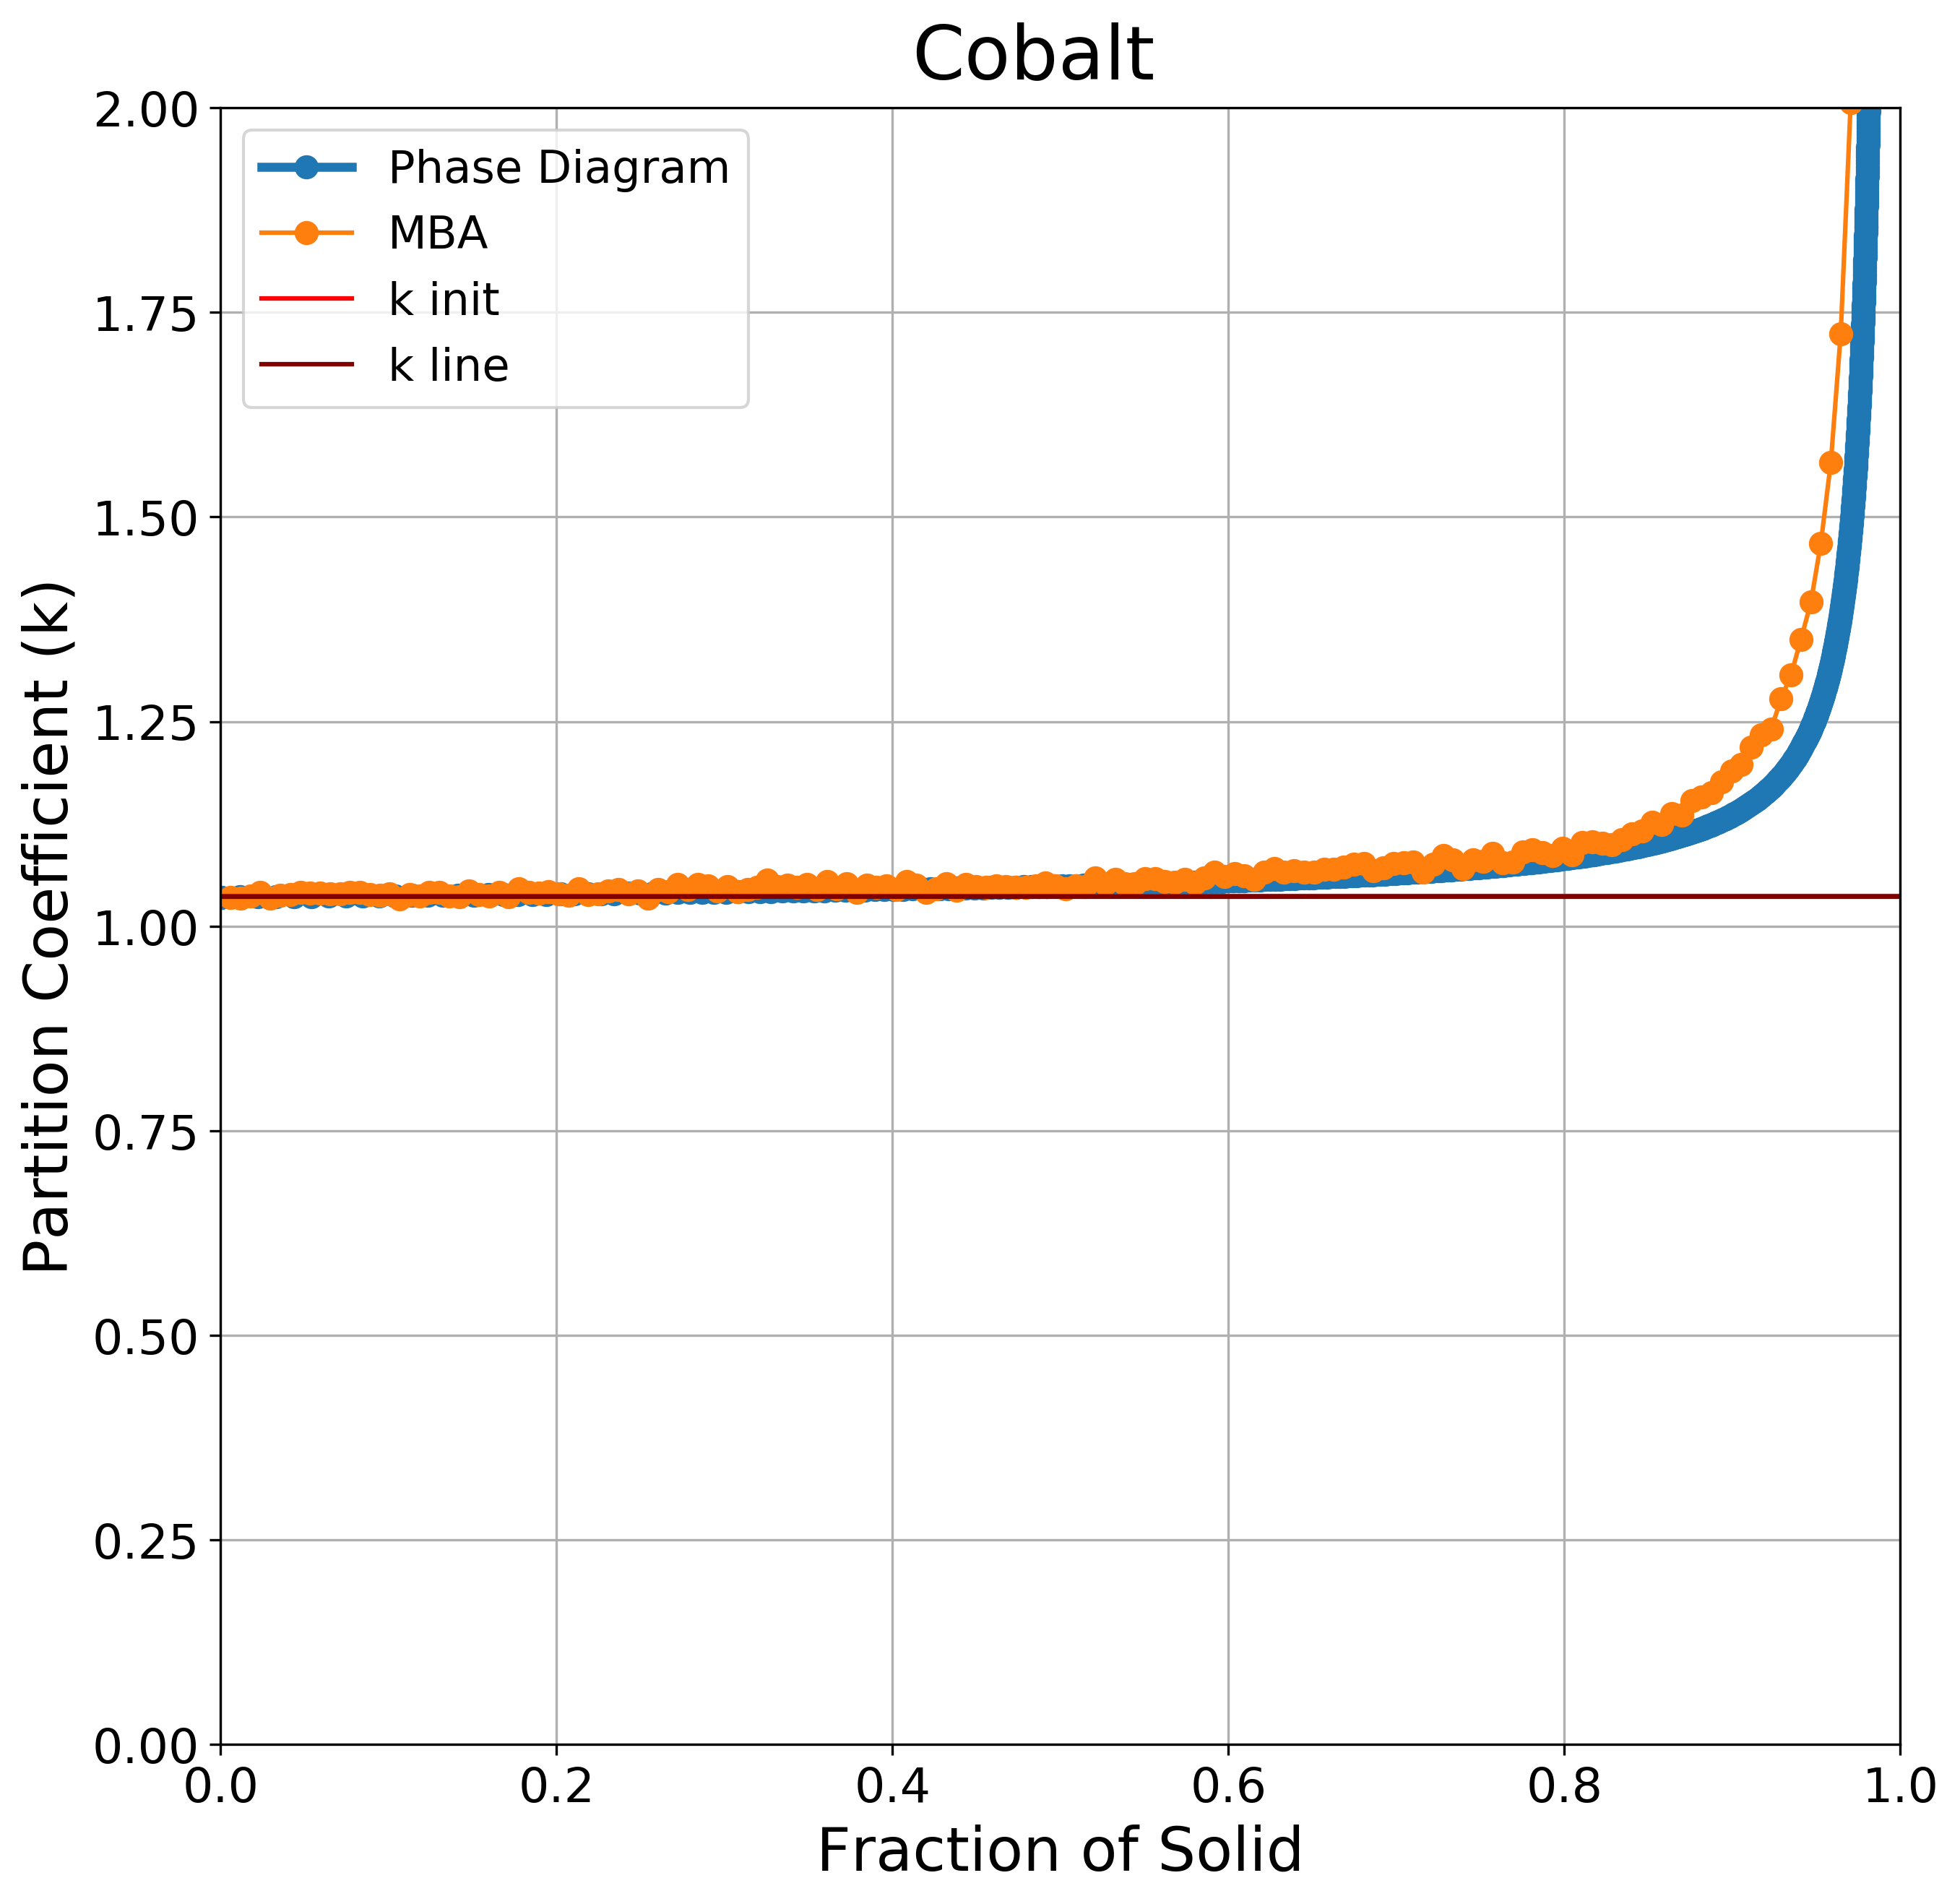

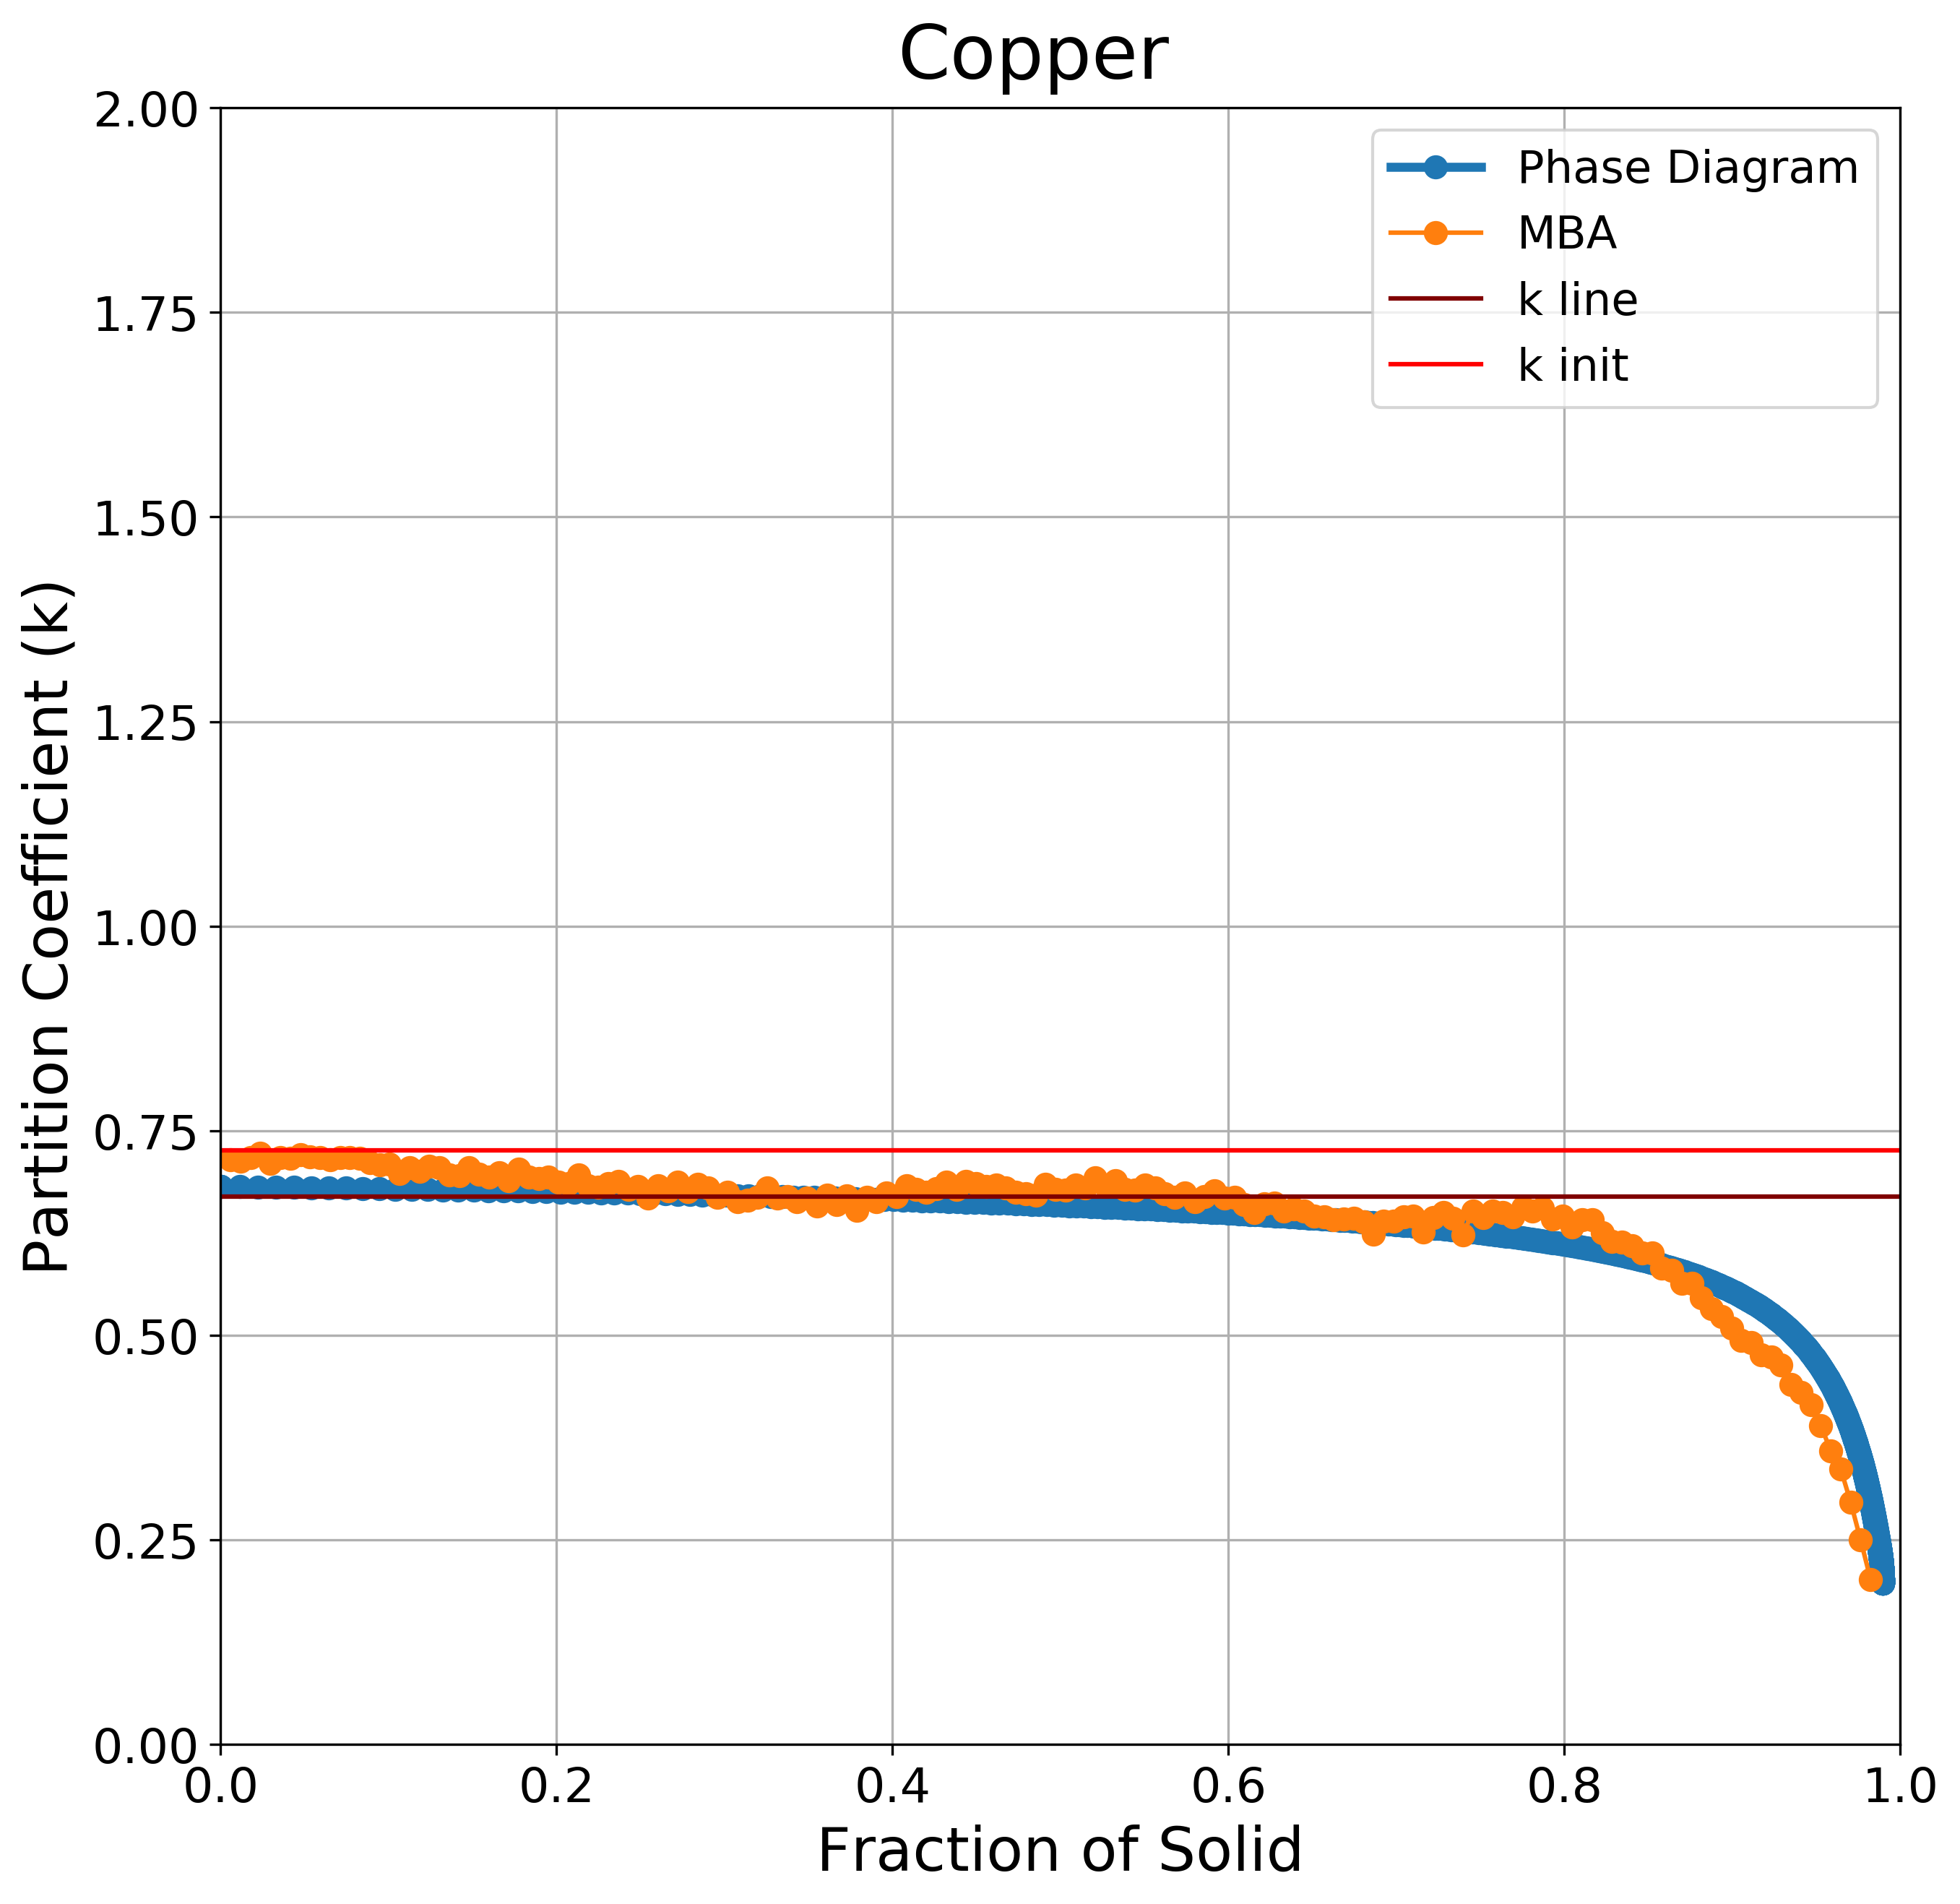

In [6]:
#Create Labels for the plots and set column names to call within the loop
graph_labels= np.array(['Cobalt', 'Copper'])
columns= np.array(['Co Elemental Percents', 'Cu Elemental Percents'])
phase_diagram_x=pddata['Mass fraction of solid']
phase_diagram_y= [pddata['kCo'], pddata['kCu']]

#Set C0 value according to values defined above
cinit= (C0Co, C0Cu)

#Generate a loop to cycle through each element in the system (in this case just Cu and Co)
#Set starting values for the loop which reset for each element's calculation
for i in range (0,2):
    fs_incr=f_solidi[1]-f_solidi[0]
    fs=0
    el_conc=cinit[i]
    mass_el_in_solid=0 #assume 100% liquid to start
    mass_el_in_liq= el_conc #CL=Co at FL=1
    data_array= np.array([['k', 'fs', 'cs_at_fs', 'cl_at_fs']])
    
#Create loop to calculate k at each WDS point using a mass balance to keep track of solute in 
#solid and liquid phases   
    for x in range (0,int(len(primary_sort["Fsolid"]))):
        
#the concentration of solid for every value of fs taken from the WIRS analysis data
        cs_at_fs= ((primary_sort.iloc[x][str(columns[i])]))
    
#The total fraction solid is the sum of all of the incrememnts (total loop cycles)
        fs= fs+fs_incr
        fl= (1-fs)
        
#the mass of solute in the solid can be continuously summed as the fraction solid increases
        mass_el_in_solid= mass_el_in_solid+(fs_incr*cs_at_fs)
    
#The liquid concentration is equal to the total mass of starting solid solute 
#(starting mass*nominal concentration where system mass=1), minus the solid already accounted for in the solid phase
        mass_el_in_liq= (el_conc- mass_el_in_solid)
    
#k can thus be calculated as a function of fraction solid and stored in a numpy array
        cl_at_fs= (mass_el_in_liq/(fl))
        k= (cs_at_fs/cl_at_fs)
        data_array=np.append(data_array,np.array([[k, fs, cs_at_fs, cl_at_fs]]),axis=0)

#remove labels from numpy array and plot the data
    data_array= np.delete(data_array,0,0)
    data_array= data_array.astype(np.float)
    primary_sort["K "+str(graph_labels[i])]=data_array[:,0]
    primary_sort["Fs "+str(graph_labels[i])]=data_array[:,1]
    primary_sort["Cs "+str(graph_labels[i])]=data_array[:,2]
    primary_sort["CL "+str(graph_labels[i])]=data_array[:,3]
    
#k init and k line values can be plotted along side the MBA values
    kinitCo= KinitCo
    klineCo= KCo_line
    kinitCu= KinitCu
    klineCu= KCu_line
    
#Plots k as a function of fraction solid for both Co and Cu with the option to include kinit and kline values
    fig1, ax= plt.subplots(figsize= (10,10), dpi=300)
    title= graph_labels[i]
    fig1.suptitle(title, fontsize=25).set_position([0.5,.92])
    ax.set_xlabel("Fraction of Solid", fontsize=20)
    ax.set_ylabel("Partition Coefficient (k)", fontsize=20)
    ax.set(xlim=(0,1), ylim=(0, 2))
    plt.plot(phase_diagram_x, phase_diagram_y[i], marker='o', label= 'Phase Diagram', markersize=7, linewidth=3)
    plt.plot(data_array[:,1], data_array[:,0], marker='o', label= 'MBA', markersize=7)
    if i==0:
        plt.axhline(kinitCo, color="red",label='k init')
        plt.axhline(klineCo, color="maroon",label='k line')
    else:
        plt.axhline(klineCu, color="maroon",label='k line')
        plt.axhline(kinitCu, color="red",label='k init')
    #plt.plot(kinitCo[:,0], kinitCo[:,1], marker='o', label= 'k init = k line')
    #plt.plot(kinitCu[:,0], kinitCu[:,1], label= 'k init', linewidth=6, color='r')
    #plt.plot(klineCu[:,0], klineCu[:,1], label= 'k line', linewidth=5, color='black')
    #plt.plot(klineCu[:,0], klineCu[:,1], label= 'k line', linewidth=5, color='black')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

# Liquid Concentration Plots

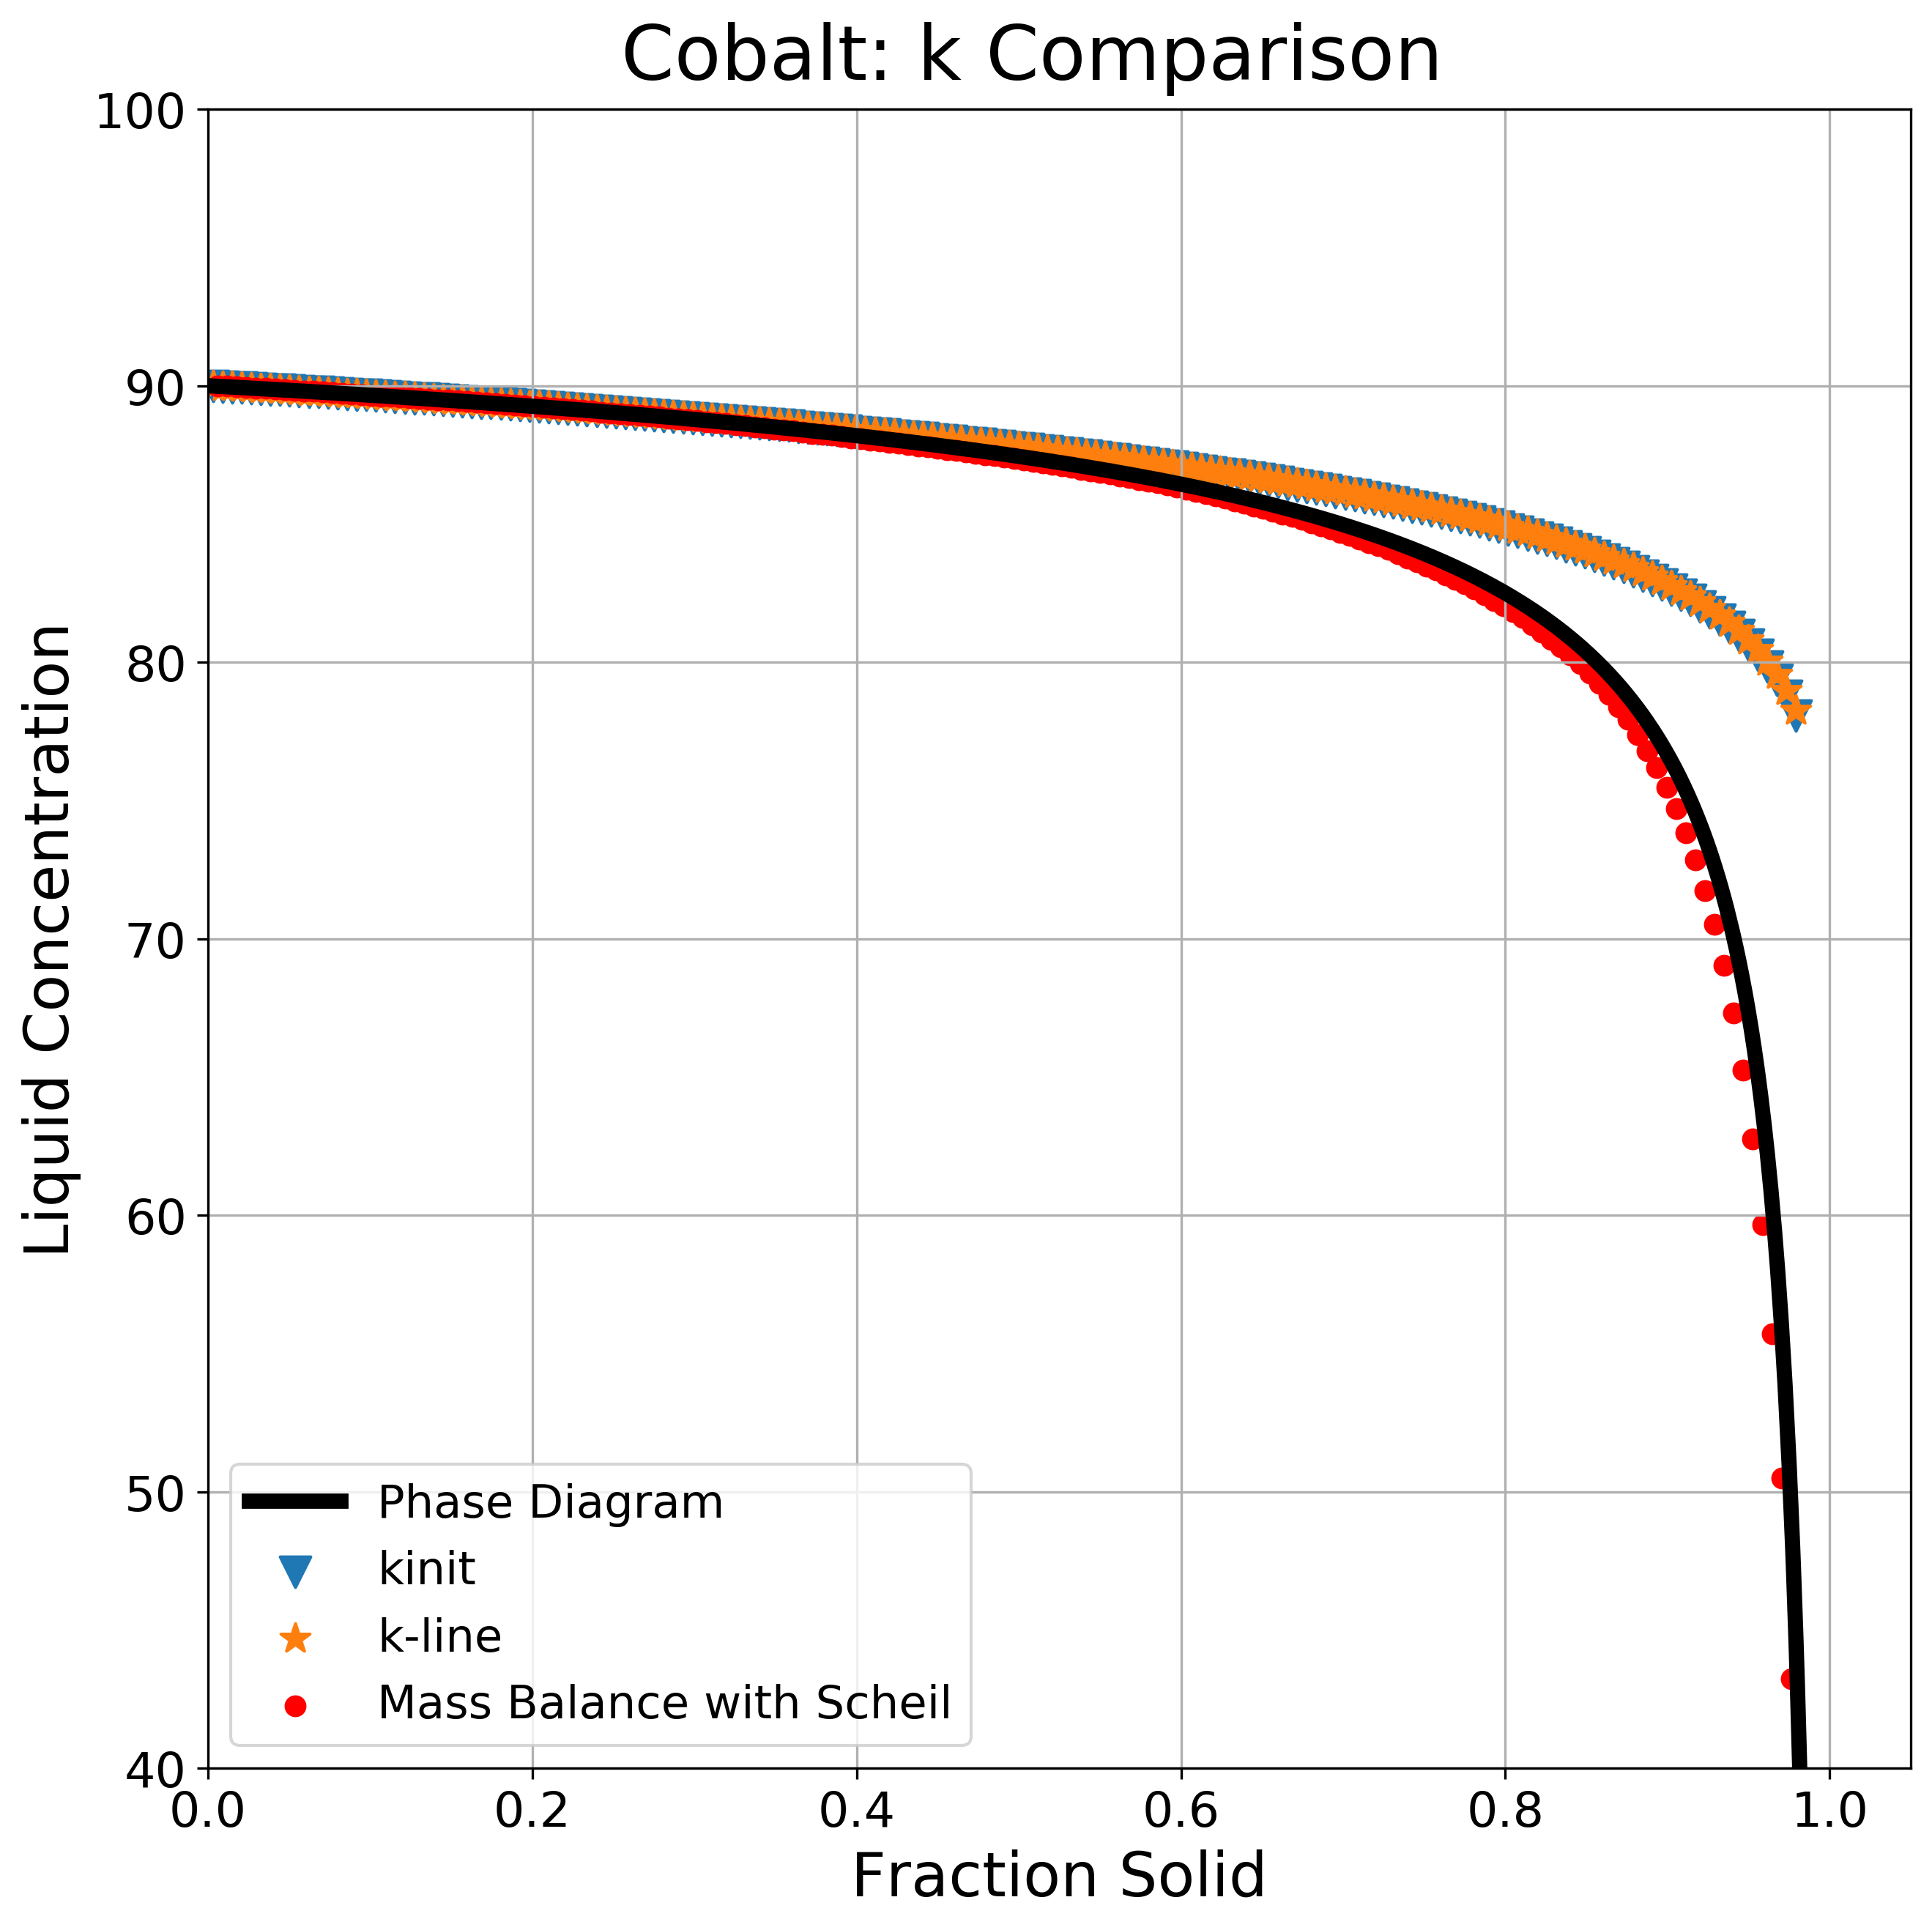

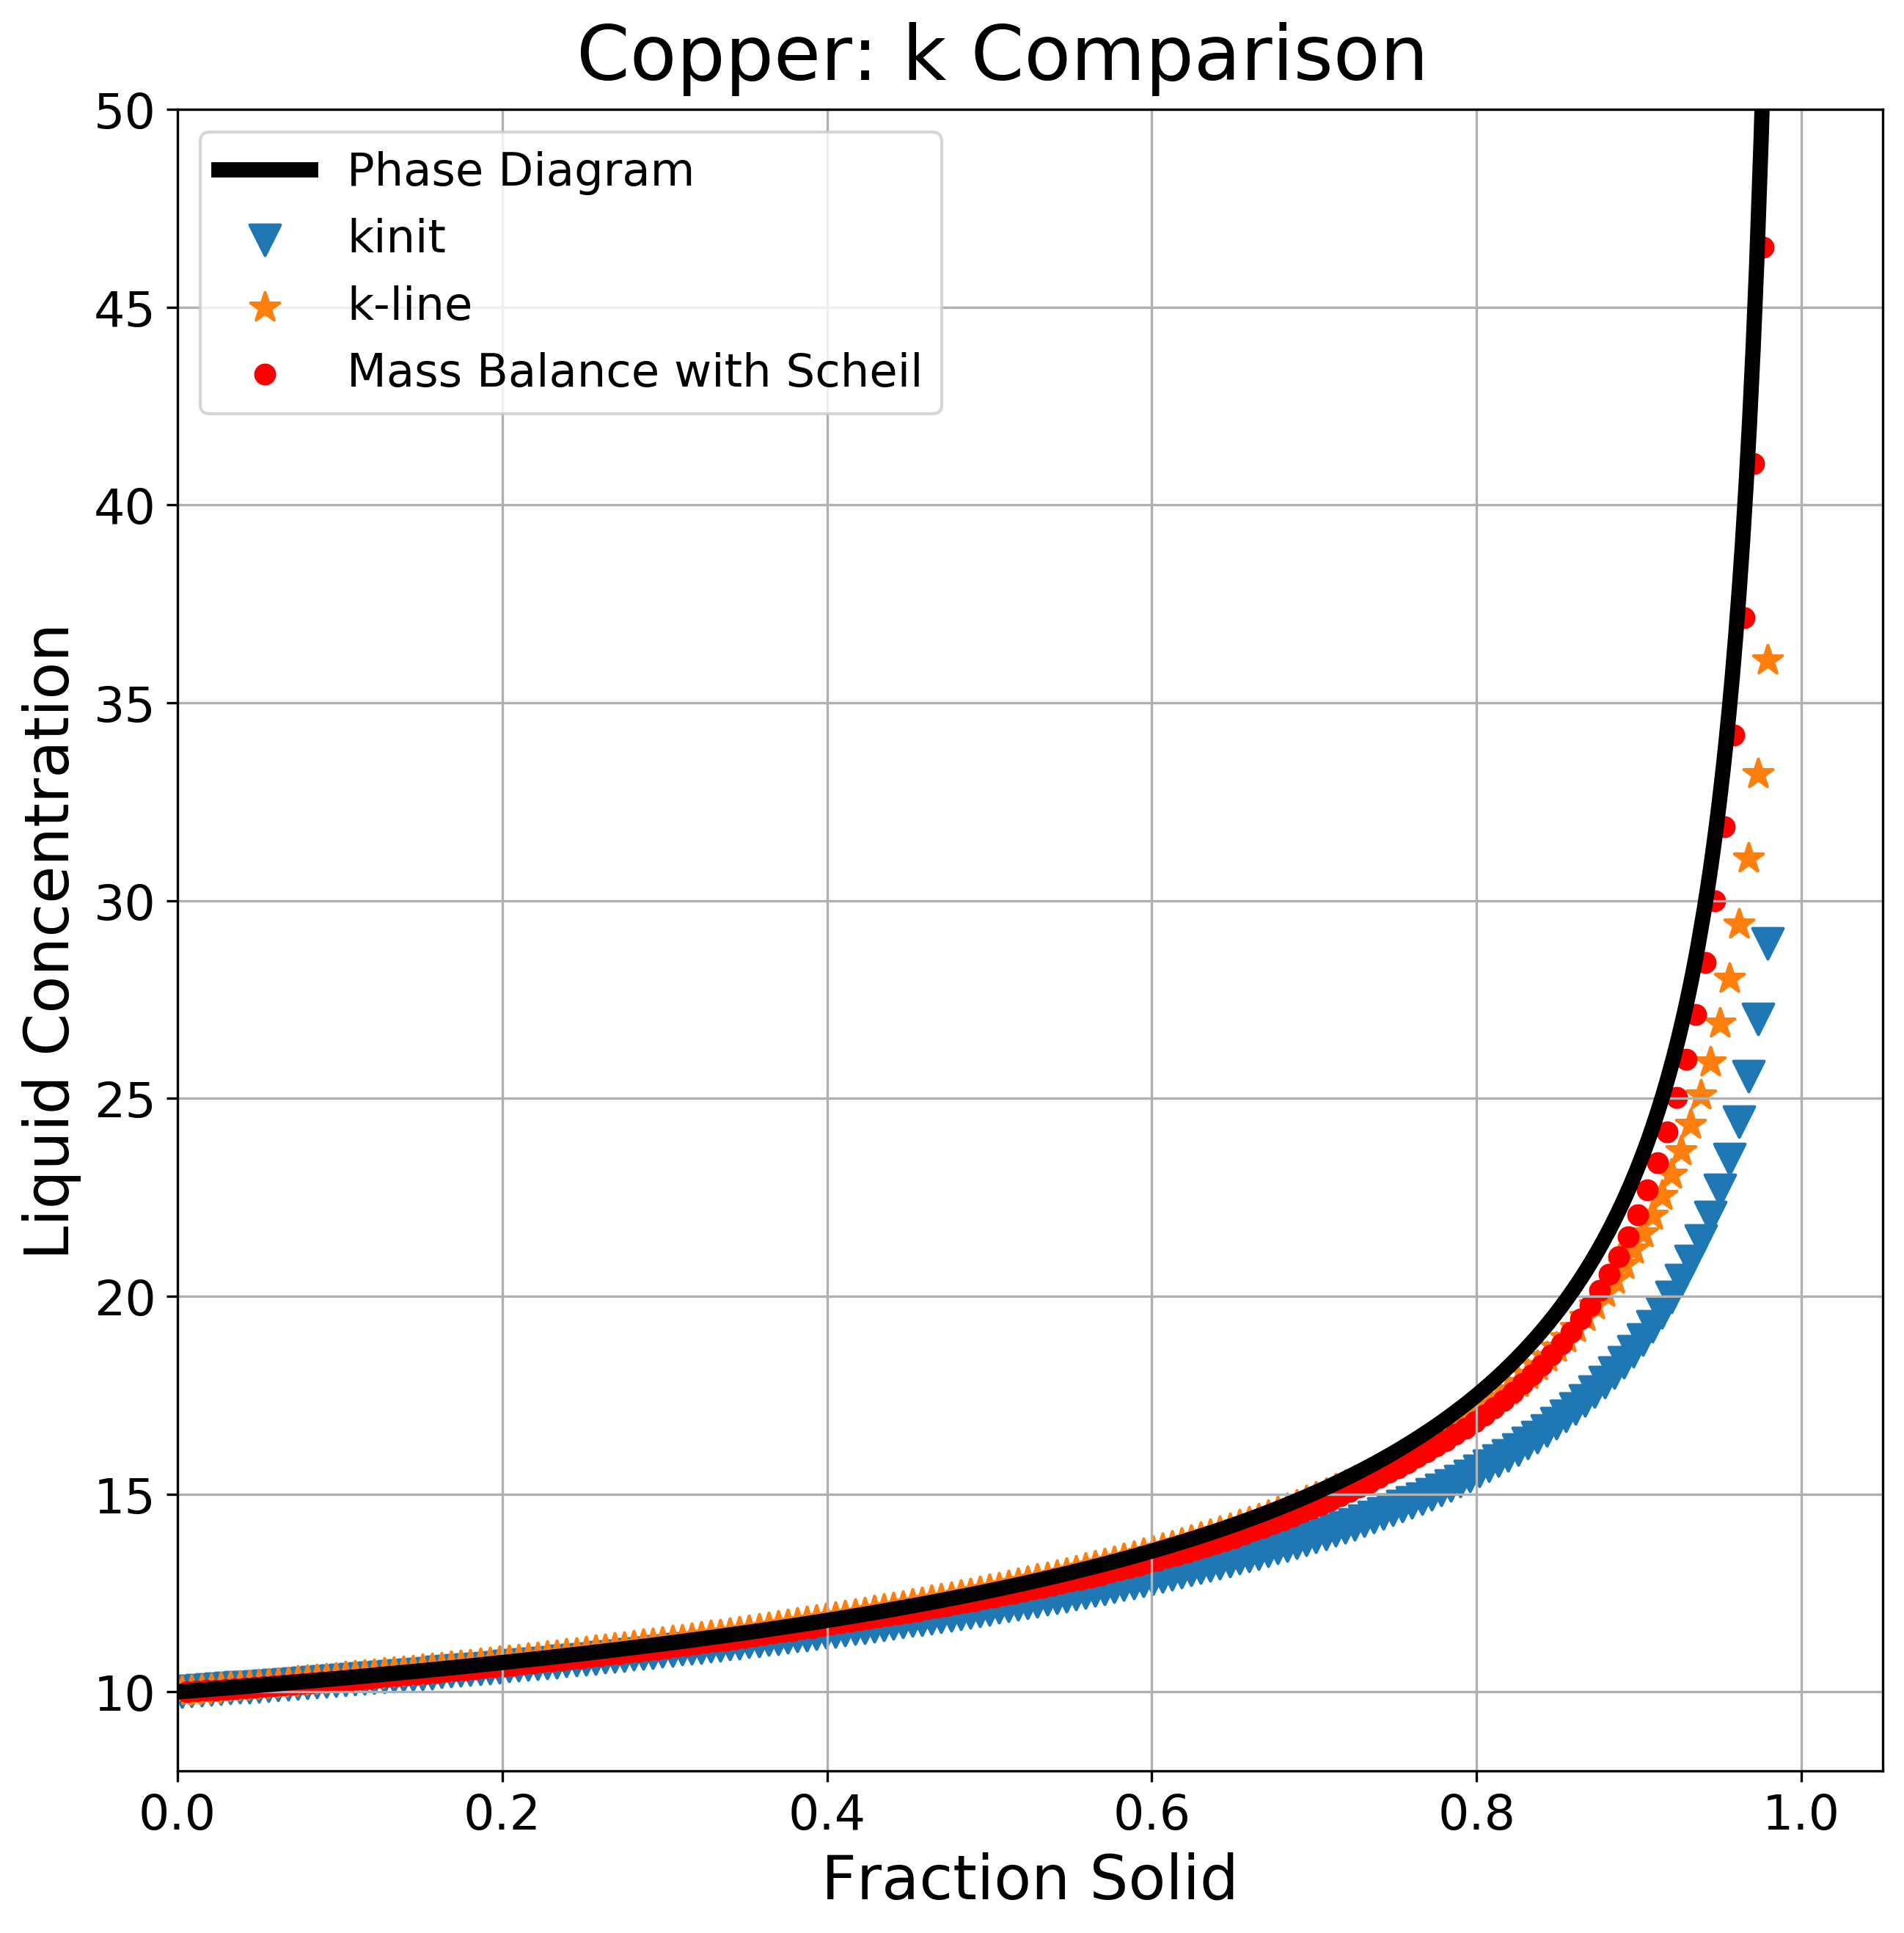

In [7]:
#Declare k line values if they are to be included in later plots
kinitCo= KinitCo
klineco= KCo_line
kinitCu= KinitCu
klinecu= KCu_line

#Define the scheil equation to generate liquid concentration plots for k init and k line values
def scheil(k,Cnom,fs):
       return Cnom*(1-fs)**(k-1)
    
kinit_NEQ_Co= scheil(KinitCo, 90, primary_sort['Fsolid'])
kinit_NEQ_Cu= scheil(KinitCu, 10, primary_sort['Fsolid'])

kline_NEQ_Co= scheil(klineco, 90, primary_sort['Fsolid'])
kline_NEQ_Cu= scheil(klinecu, 10, primary_sort['Fsolid'])



# The differential Scheil equation is easier to define in loops. One loop for Co and one for Cu
#start by setting some initial values where coclprev is the nominal Co composition
coclprev= 90
dfs= f_solid[1]- f_solid[0]
cocl_array= np.array([['fs', 'cs']])
fs=0

#Apply differential Scheil equation using Co MBA data
for i in range (0, len(primary_sort['Co Elemental Percents'])):
    
#Calculates the slope of the liquidus line created from the MBA
    coclcur= primary_sort['CL Cobalt'][i]
    dcocl= coclcur-coclprev
    cocs= primary_sort['Cs Cobalt'][i]
    fs= fs+dfs
#Applies the equation and stores liquid composition as a function of fraction solid in an array
    cocl_differential= cocs+((1-fs)*(dcocl/dfs))
    array= np.array([[fs, cocl_differential]])
    cocl_array= np.append(cocl_array, array, axis=0)
    coclprev= coclcur
    
#Deletes headings of Co data for use in plotting
cocl_array= np.delete(cocl_array,0,0) 
cocl_array= cocl_array.astype('float')


#Set initial values for use in the differential scheil equation for Cu
cuclprev= 10
dfs= f_solid[1]- f_solid[0]
cucl_array= np.array([['fs', 'cs']])
fs=0

#Applies differential Scheil equation using Cu MBA data
for i in range (0, len(primary_sort['Cu Elemental Percents'])):
    
#Calculates the slope of the liquidus line created from the MBA
    cuclcur= primary_sort['CL Copper'][i]
    dcucl= cuclcur-cuclprev
    cucs= primary_sort['Cs Copper'][i]
    fs= fs+dfs
    
#Apples the equation and stores liquid composition as a function of fraction solid in an array
    cucl_differential= cucs+((1-fs)*(dcucl/dfs))
    array= np.array([[fs, cucl_differential]])
    cucl_array= np.append(cucl_array, array, axis=0)
    cuclprev= cuclcur
    
#Deletes headings of Cu data for use in plotting
cucl_array= np.delete(cucl_array,0,0) 
cucl_array= cucl_array.astype('float')

#Plots the liquid concentration curves of Co as a function of fraction solid
fig1, ax= plt.subplots(figsize= (10,10), dpi=300)
title= 'Cobalt: k Comparison'
fig1.suptitle(title, fontsize=25).set_position([0.5,.92])
ax.set_xlabel("Fraction Solid", fontsize=20)
ax.set_ylabel("Liquid Concentration", fontsize=20)
plt.scatter(primary_sort['Fsolid'], kinit_NEQ_Co, marker = 'v', s=100, label= 'kinit')
plt.scatter(primary_sort['Fsolid'], kline_NEQ_Co, marker= '*', s=100, label= 'k-line')
plt.plot(pddata['Mass fraction of solid'], pddata['Mass percent of Co in LIQUID'],linewidth= 5, color= 'black', label= 'Phase Diagram')
plt.scatter(cocl_array[:,0], cocl_array[:,1],color= 'r', s=38, label= 'Mass Balance with Scheil')
ax.set(xlim=(0,1.05), ylim=(40, 100))
plt.legend(loc= 'lower left', fontsize=15)
plt.grid()
plt.show()


#Plots the liquid composition curves of Cu as a function of fraction solid
fig2, ax= plt.subplots(figsize= (10,10), dpi=300)
title= 'Copper: k Comparison'
fig2.suptitle(title, fontsize=25).set_position([0.5,.92])
ax.set_xlabel("Fraction Solid", fontsize=20)
ax.set_ylabel("Liquid Concentration", fontsize=20)
plt.scatter(primary_sort['Fsolid'], kinit_NEQ_Cu, marker= 'v', s=100, label= 'kinit')
plt.scatter(primary_sort['Fsolid'], kline_NEQ_Cu, marker= '*', s=100,label= 'k-line')
plt.plot(pddata['Mass fraction of solid'], pddata['Mass percent of Cu in LIQUID'],linewidth= 5, color= 'black', label= 'Phase Diagram')
plt.scatter(cucl_array[:,0], cucl_array[:,1],color= 'r', s=38, label= 'Mass Balance with Scheil')
#plt.scatter(data_array[:,1], data_array[:,3], marker= '*', s=100, label= 'Actual CL from MBA')
ax.set(xlim=(0,1.05), ylim=(8, 50))
plt.legend(loc= 'upper left', fontsize=15)
plt.grid()
plt.show()